In [53]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
sns.set(color_codes=True)

# Visualize result

### 1. Load results

In [108]:
feature_set = {'None': 'F-0', 
               'skipgram_ce_nm_ws_60_dim_100_epoch_1': 'F-SMF-1', 
               'skipgram_ce_nm_ws_180_dim_100_epoch_1': 'F-SMF-3',
               'skipgram_ce_nm_ws_360_dim_100_epoch_1': 'F-SMF-6'}
los_set = {'95-percentile': 'G-2',
           '90-percentile': 'G-3',
           '30-percentile': 'G-5',
           '10-percentile': 'G-11',}
test_score_names = ['test_acc', 
                    'test_ami', 
                    'test_ari',] 
#                     'test_mi', 'test_mmi', 'test_v_measure']

In [87]:
def rename_pretrained_path(x):
    if pd.isna(x):
        return feature_set['None']
    else:
        name = x.split('/')[-1].split('.')[0]
        return feature_set[name]

In [330]:
# get all result files
result_dir = '../backup'
result_paths = [join(result_dir, f) for f in listdir(result_dir)
                if isfile(join(result_dir, f)) and 'grid_search_result' in f]
print('result_paths: ', result_paths)

# load to dataframe
df = pd.concat([pd.read_csv(result_path) for result_path in result_paths], ignore_index=True)

# rename
df['pretrained_path'] = df['pretrained_path'].apply(rename_pretrained_path)
df['los_group'] = df['los_group'].apply(lambda x: los_set[x])
df['epoch'] = df['epoch'].apply(lambda x: str(x))
df['test_acc'] = df['test_acc'].apply(lambda x: x * 100)
df['train_acc'] = df['train_acc'].apply(lambda x: x * 100)
print('shape: ', df.shape)

# df.head()

result_paths:  ['../backup/grid_search_result_95percentile.csv', '../backup/grid_search_result_30percentile.csv', '../backup/grid_search_result_90percentile.csv']
shape:  (38, 16)


In [171]:
# df.groupby(['los_group', 'pretrained_path'])['test_acc'].max()

In [336]:
# keep the max accuracy for each los_group, pretrained_path
df.sort_values('epoch', inplace=True)
max_accuracy_groups =  df.groupby(['los_group', 'pretrained_path'])['test_acc'].max()
best_acc_rows = list()
for _, row in df.iterrows():
    if len(max_accuracy_groups) == 0:
        break
    for name in max_accuracy_groups.index:
        if row['los_group'] == name[0] and row['pretrained_path'] == name[1] \
            and row['test_acc'] == max_accuracy_groups.loc[name]:
            best_acc_rows.append(row)
            max_accuracy_groups.drop(name, inplace=True)
            break
best_acc_df = pd.DataFrame(best_acc_rows)
print(best_acc_df.shape)
best_acc_df.head(10)

(8, 16)


,avg_loss,epoch,los_group,pretrained_path,test_acc,test_ami,test_ari,test_mi,test_mmi,test_v_measure,train_acc,train_ami,train_ari,train_mi,train_mmi,train_v_measure
0,0.344011,1,G-2,F-0,94.508521,2.609345e-16,0.000000,5.551115e-17,5.551115e-07,5.218690e-16,94.896987,-0.000056,0.001616,0.000024,0.000777,0.000238
16,1.613678,1,G-5,F-0,41.899727,1.066817e-01,0.092618,1.543419e-01,1.288719e-01,1.266975e-01,41.953769,0.070516,0.077193,0.100778,0.082880,0.081883
12,0.200101,1,G-2,F-SMF-6,94.508521,2.609345e-16,0.000000,5.551115e-17,5.551115e-07,5.218690e-16,94.911650,0.000037,0.001896,0.000040,0.001429,0.000388
8,0.202017,1,G-2,F-SMF-1,94.508521,2.609345e-16,0.000000,5.551115e-17,5.551115e-07,5.218690e-16,94.918982,-0.000062,-0.000415,0.000011,0.000561,0.000113
4,0.199299,1,G-2,F-SMF-3,94.508521,2.609345e-16,0.000000,5.551115e-17,5.551115e-07,5.218690e-16,94.896987,-0.000047,-0.000826,0.000023,0.000824,0.000224
22,1.210243,3,G-5,F-SMF-3,43.127558,1.092526e-01,0.100796,1.583581e-01,1.273989e-01,1.260196e-01,45.833333,0.114695,0.115534,0.163529,0.128866,0.128045
34,0.667085,3,G-3,F-0,86.038905,2.842983e-02,0.082334,1.468085e-02,7.380215e-02,5.016545e-02,87.352445,0.020407,0.064090,0.009699,0.061453,0.036985
28,1.226426,3,G-5,F-SMF-6,43.656207,1.062653e-01,0.096344,1.540732e-01,1.230575e-01,1.218514e-01,46.083628,0.105238,0.111529,0.150093,0.119278,0.118401


### 2.  Evaluate the effectiveness of Skip-MF

In [293]:
def visual_effective_skipmf(all_data, los_groups, score='test_acc', ylabel='', fname=None):
    # x: pretrained_path, y: accuracy, ami, ari
    
    nrows = 2
    ncols = int(len(los_groups)/2)
    f, axes = plt.subplots(nrows, ncols, figsize=(10, 8))
    plt.subplots_adjust(wspace=0.3, hspace=0.35)
    
    x = sorted(best_acc_df['pretrained_path'].unique())
    
    for index, los_group in enumerate(los_groups):
        # filter data
        data = all_data[(all_data.los_group == los_group)][['pretrained_path', score]]
        data.set_index('pretrained_path', inplace=True)
        data.sort_index(inplace=True)
        if len(data) != len(x):
            continue
        
        ax = axes[int(index / nrows), index % ncols]
        sns_plot = sns.lineplot(x=x, y=data[score].tolist(), palette="tab10", ax=ax)
        ax.set_ylabel(ylabel)
        ax.set_xlabel('%s' % los_group)

    if fname is not None:
        f.savefig(fname)

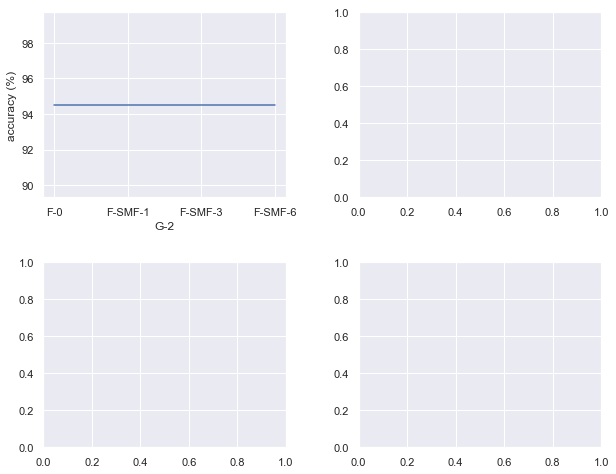

In [332]:
visual_effective_skipmf(best_acc_df, los_groups=los_set.values(), score='test_acc',
                        ylabel="accuracy (%)", fname='../backup/effective_skipmf_acc.png')

In [290]:
# visual_effective_skipmf(best_acc_df, los_groups=los_set.values(), score='test_ami',
#                         ylabel='AMI score', fname='../backup/effective_skipmf_ami.png')

In [289]:
# visual_effective_skipmf(best_acc_df, los_groups=los_set.values(), score='test_ari',
#                         ylabel='ARI score', fname='../backup/effective_skipmf_ari.png')

### 3. Evaluate the effectiveness of different LOS groups
- x : los_group, y: scores

In [321]:
def visual_effective_los_groups(all_data, pretrained_paths, score='test_acc', ylabel='', fname=None):
    # x : los_group, y: scores (accuracy, ami, ari)
    
    nrows = 2
    ncols = int(len(pretrained_paths)/2)
    
    f, axes = plt.subplots(nrows, ncols, figsize=(10, 8))
    plt.subplots_adjust(wspace=0.3, hspace=0.35)
    
    x = sorted(best_acc_df['los_group'].unique())
    
    for index, pretrained_path in enumerate(pretrained_paths):
        # filter data
        data = all_data[(all_data.pretrained_path == pretrained_path)][['los_group', score]]
        data.set_index('los_group', inplace=True)
        data.sort_index(inplace=True)
        if len(data) != len(x):
            continue
        
        ax = axes[int(index / nrows), index % ncols]
        sns_plot = sns.lineplot(x=x, y=data[score].tolist(), palette="tab10", ax=ax, markers=True)
        ax.set_ylabel(ylabel)
        ax.set_xlabel('%s' % pretrained_path)

    if fname is not None:
        f.savefig(fname)

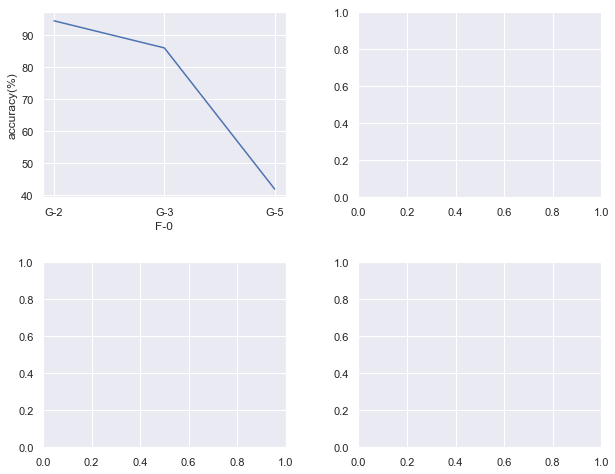

In [333]:
visual_effective_los_groups(best_acc_df, pretrained_paths=feature_set.values(), score='test_acc',
                            ylabel='accuracy(%)', fname='../backup/effective_los_groups_acc.png')

In [335]:
for i in reversed([1,2,3]):
    print(i)

3
2
1


## 4.  Evaluate the effectiveness of different window size

In [328]:
def visual_effective_window_size(all_data, score='test_acc', ylabel='', fname=None):
    # x : window size, y: scores (accuracy, ami, ari)
    
    # filter data
    window_sizes = {'F-SMF-1': 60,
                    'F-SMF-3': 180,
                    'F-SMF-6': 360}
    list_data = []
    for index, row in all_data.iterrows():
        if row['pretrained_path'] in window_sizes:
            list_data.append({'window size': window_sizes[row['pretrained_path']],
                         row['los_group']: row['test_acc']})
    data = pd.DataFrame(list_data)
    data.set_index('window size', inplace=True)
    data.sort_index(inplace=True)
    print(data)
    
    sns_plot = sns.lineplot(data=data, palette="tab10", markers=True)
    sns_plot.set_ylabel(ylabel)
    
    f = sns_plot.get_figure()
    f.set_figure((10,10))
    f.show()

    if fname is not None:
        f.savefig(fname)

                   G-2
window size           
60           94.508521
180          94.508521
360          94.508521


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


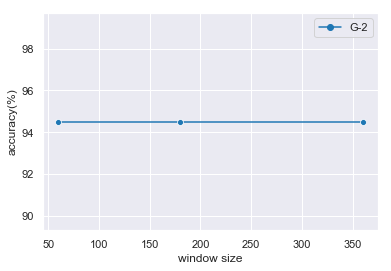

In [329]:
visual_effective_window_size(best_acc_df, score='test_acc', ylabel='accuracy(%)',
                            fname='../backup/effective_window_size.png')

### *.Evaluate scores over epoch

In [180]:
# columns = ['epoch']
# columns.extend(test_score_names)
# # select epoch having max accuracy
# data = df[(df.pretrained_path == 'F-0') & (df.los_group == 'G-5')][columns]
# data.set_index('epoch', inplace=True)
# data.sort_index(inplace=True)

# plt.subplots(figsize=(8, 5))
# sns_plot = sns.lineplot(data=data, palette="tab10")
# fig = sns_plot.get_figure()
# fig.show()